In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mplfinance as mpf
import talib as ta

In [2]:
Catcolors = {
    "rosewater": "#f5e0dc",
    "flamingo":  "#f2cdcd",
    "pink":      "#f5c2e7",
    "mauve":     "#cba6f7",
    "red":       "#f38ba8",
    "maroon":    "#eba0ac",
    "peach":     "#fab387",
    "yellow":    "#f9e2af",
    "green":     "#a6e3a1",
    "teal":      "#94e2d5",
    "sky":       "#89dceb",
    "blue":      "#74c7ec",
    "lavender":  "#b4befe",
    "text":      "#cdd6f4",
    "subtext1":  "#bac2de",
    "subtext0":  "#a6adc8",
    "surface0":  "#1e1e2e",
    "surface1":  "#313244",
    "surface2":  "#45475a",
}

Chartinfos = {
    "interval": 15,
    "title" : "Chart for 15MIN interval"
}

# printthis = f"lorem ipsum dollar {Chartinfos['interval']}"

# print(printthis)

In [3]:
# Load the MT5 CSV
df = pd.read_csv( "xauusdm15.filtered.csv" )

# Set DateTime as index
df['DateTime'] = pd.to_datetime(df["DateTime"])
df.set_index("DateTime", inplace=True)

# Optional: keep only OHLC + Volume for plotting
ohlc_df = df[["Open", "High", "Low", "Close", "Volume"]]

print(ohlc_df.head())

                         Open      High       Low     Close  Volume
DateTime                                                           
2024-01-01 23:00:00  2064.593  2066.092  2063.301  2065.142      10
2024-01-01 23:15:00  2065.159  2065.900  2064.443  2064.698      15
2024-01-01 23:30:00  2064.664  2065.131  2063.634  2064.258      15
2024-01-01 23:45:00  2064.259  2064.259  2062.643  2063.543      14
2024-01-02 00:00:00  2063.347  2064.932  2063.331  2064.006      15


In [4]:
plot_data = ohlc_df.tail(300).copy()
plot_data = plot_data.reset_index()

# Compute RSI and Moving Averages
plot_data['RSI'] = ta.RSI(plot_data['Close'], timeperiod=14)
plot_data['EMA21'] = ta.SMA(plot_data['Close'], timeperiod=21)
plot_data['EMA51'] = ta.SMA(plot_data['Close'], timeperiod=51)

# Difference
plot_data['Diff'] = plot_data['EMA21'] - plot_data['EMA51']
plot_data['CrossSignal'] = plot_data['Diff'].apply(np.sign).diff()
plot_data['CrossSignal'] = plot_data['CrossSignal'].map({2: 1, -2: -1}).fillna(0)  # 1 = bullish, -1 = bearish

# Trim initial rows
Strat_from = 30
plot_data = plot_data.iloc[Strat_from:]

# Show last 3 rows
plot_data.iloc[:, 6:].tail(3)

,RSI,EMA21,EMA51,Diff,CrossSignal
297,56.233516,2624.492857,2618.421039,6.071818,0.0
298,57.776547,2624.535048,2618.577157,5.957891,0.0
299,57.151027,2624.458048,2618.782431,5.675616,0.0


In [5]:
lorem = plot_data.iloc[:, 6:]
lorem = lorem[lorem['CrossSignal'] != 0]

lorem.tail(3)


,RSI,EMA21,EMA51,Diff,CrossSignal
220,53.263222,2607.317476,2607.113706,0.203770,1.0
242,63.561229,2606.864619,2606.880784,-0.016165,-1.0
243,68.430448,2607.110619,2607.054980,0.055639,1.0


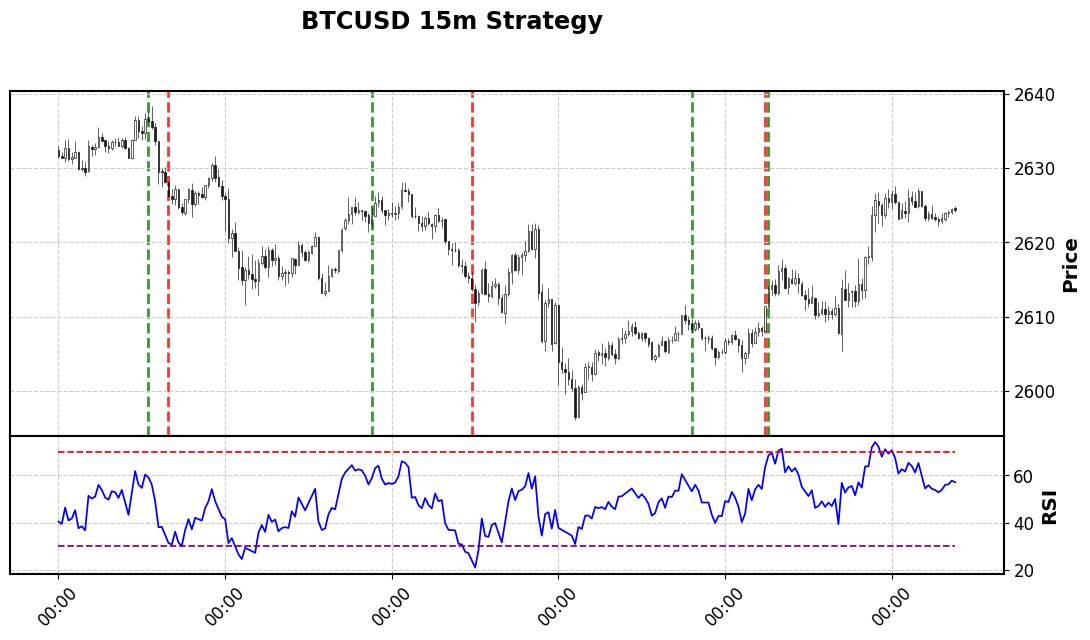

In [6]:
import mplfinance as mpf
import pandas as pd
import matplotlib.pyplot as plt


class CandlePlotter:
    def __init__(self, data: pd.DataFrame, chart_info: dict):
        """
        data: DataFrame with OHLC and CrossSignal columns (and ideally RSI column)
        chart_info: dict with config like {"title": "My Chart"}
        """
        self.data = data.copy()
        self.data.index = pd.to_datetime(self.data.index)  # Ensure datetime index
        self.chart_info = chart_info

    def plot(self, show_rsi: bool = True):
        """Plot candlestick chart with CrossSignal lines and optional RSI subplot."""

        addplots = []

        if show_rsi and "RSI" in self.data.columns:
            addplots.append(
                mpf.make_addplot(
                    self.data["RSI"],
                    panel=1,              # plot on 2nd panel
                    color="blue",
                    ylabel="RSI"
                )
            )
            # Add overbought/oversold lines
            addplots.append(mpf.make_addplot([70] * len(self.data), panel=1, color="red", linestyle="--"))
            addplots.append(mpf.make_addplot([30] * len(self.data), panel=1, color="purple", linestyle="--"))

        # Create candlestick chart
        fig, axes = mpf.plot(
            self.data,
            type='candle',
            style='classic',
            volume=False,
            figratio=(14, 7),
            figscale=1.2,
            returnfig=True,
            title=self.chart_info.get("title", "Candlestick Chart"),
            addplot=addplots
        )

        # Overlay vertical lines based on CrossSignal
        if "CrossSignal" in self.data.columns:
            for i, signal in enumerate(self.data["CrossSignal"]):
                if signal == -1:
                    axes[0].axvline(x=i, color="red", linestyle="--", alpha=0.8, zorder=0)
                elif signal == 1:
                    axes[0].axvline(x=i, color="green", linestyle="--", alpha=0.8, zorder=0)

        plt.show()


# --- Example Usage ---
Chartinfos = {"title": "BTCUSD 15m Strategy"}

# Example DataFrame: must have OHLCV + CrossSignal + RSI
# plot_data = your dataframe here

plotter = CandlePlotter(plot_data, Chartinfos)
plotter.plot(show_rsi=True)   # show RSI subplot


In [9]:
plot_data.to_csv('15MIN-Updated.csv', index=False)